# Logistic Regression Training
Binary classification algorithm.
Typically used when the target variable has only two possible outcomes.

However, logistic regression can be extended to handle multi-class classification problems through techniques such as *one-vs-all* or *multinomial* logistic regression.

## One-vs-all or One-vs-Rest (OVR)
Train separate binary logistic regression model for each class.
Each model is trained to distinguish that class from all other classes.
During prediction, we run each observation through all models, and the class with the highest probability is assigned as the predicted class.

Our dataset has a discrete number of possible outcomes: `[Ravenclaw, Slytherin, Gryffindor, Hufflepuff]`.

This method allows breaking down by splitting up into multiple binary class models.

We will be using `k=4` *binary classifiers*.

## Features Selection
Based on data visualization:
- `Arithmancy` and `Care of magical Creatures` cannot classify well.
- `Defense Against the Dark Arts` and `Astronomy` are anti-correlated; we can drop one.

All other numerical features will be used for training.

## Data preparation
- Only meaningful features will be used
- Remove rows containing `NaN`
- *Standardize* data

## Model Training
- Input values: $X = (x_1, x_2, ..., x_n)$
- Weights: $W=(w_1, w_2, ..., w_n)$
- $b$: bias parameter

$$z=b+x_1.w_1+w_2.w_2+...+x_n.w_n = b+\sum_{i=1}^{n}{x_i.w_i}$$

**Logistic function:**
$$g(z)=\frac{1}{1+e^{-z}}=\frac{1}{1+e^{-(b+X.W)}}$$

### Matrix Notation
$X = \begin{bmatrix} 
x_{1}^{(1)} & x_{2}^{(1)} & \cdots & x_{n}^{(1)} & 1 \\ 
x_{1}^{(2)} & x_{2}^{(2)} & \cdots & x_{n}^{(2)} & 1\\ 
\vdots & \vdots & \ddots & \vdots & \vdots \\ 
x_{1}^{(m)} & x_{2}^{(m)} & \cdots & x_{n}^{(m)} & 1
\end{bmatrix}$

$W = \begin{bmatrix} 
w_{1} \\ w_{2} \\ \vdots \\ w_{n} \\ b 
\end{bmatrix}$


In [1]:
import numpy as np
import mplcatppuccin
from mplcatppuccin.palette import load_color
import matplotlib.pyplot as plt
plt.style.use("mocha")

%run "utils.ipynb"

print("Loading and preprocessing data...")
df = get_data()
# ============== DATA PREPROCESSING ================
print('Data frame shape:', df.shape)
excluded_features = ['Arithmancy', 'Care of Magical Creatures', 'Defense Against the Dark Arts']
df.drop(df.columns[1:5], inplace=True, axis=1)
df.drop(excluded_features, inplace=True, axis=1)
df.dropna(inplace=True)
print('Data frame shape after data processing:', df.shape)

# Extract houses
print("Extracting features and target...")
df_houses = df['Hogwarts House']

df_features = df.drop(df.columns[:1], axis=1)
print("Number of features:", df_features.shape[1])

# Standardize data
print("Standardizing features...")
df_std_features = df_features.apply(lambda x: (x - x.mean()) / x.std())

# ============== INITIALIZE MODEL ================
print("Initializing model parameters...")
# Create matrices
X = np.array(df_std_features)
ones = np.ones((len(X), 1), dtype=float)
# Add a columns of 1s RIGHT
X = np.concatenate((X, ones), axis=1)

features = df_std_features.columns.tolist()
houses = df_houses.unique().tolist()

w_indexes = df_std_features[:-1].columns
w_indexes = w_indexes.append(pd.Index(['Bias']))
W = pd.DataFrame(columns=houses, index=w_indexes)

# TODO: the current start weights are set to 0 - should use 1s?
W = W.infer_objects(copy=False).fillna(0)
print("Initial weights matrix:")
W.head(11)

Loading and preprocessing data...
Data frame shape: (1600, 18)
Data frame shape after data processing: (1333, 11)
Extracting features and target...
Number of features: 10
Standardizing features...
Initializing model parameters...
Initial weights matrix:


,Ravenclaw,Slytherin,Gryffindor,Hufflepuff
Astronomy,0.0,0.0,0.0,0.0
Herbology,0.0,0.0,0.0,0.0
Divination,0.0,0.0,0.0,0.0
Muggle Studies,0.0,0.0,0.0,0.0
Ancient Runes,0.0,0.0,0.0,0.0
History of Magic,0.0,0.0,0.0,0.0
Transfiguration,0.0,0.0,0.0,0.0
Potions,0.0,0.0,0.0,0.0
Charms,0.0,0.0,0.0,0.0
Flying,0.0,0.0,0.0,0.0


Training model for Ravenclaw house...
  Convergence reached at iteration 6006
Training model for Slytherin house...
  Convergence reached at iteration 7975
Training model for Gryffindor house...
  Convergence reached at iteration 6708
Training model for Hufflepuff house...
  Convergence reached at iteration 7180
Trained model saved successfully.


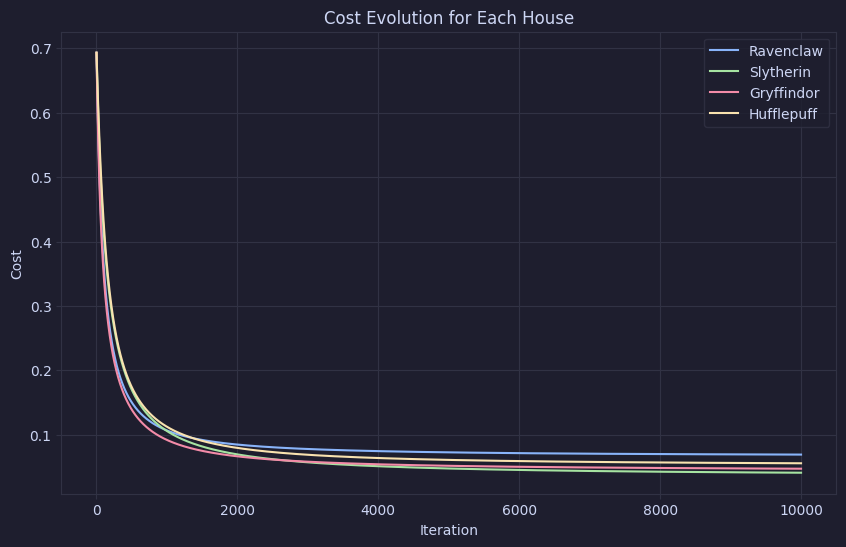


Updated weight matrix:


,Ravenclaw,Slytherin,Gryffindor,Hufflepuff
Astronomy,-1.052726,-1.035758,0.293593,1.871979
Herbology,0.413094,-0.830910,-0.892024,1.386501
Divination,0.173043,-1.640006,0.508265,0.879328
Muggle Studies,1.381553,-0.340681,-0.164253,-0.941789
Ancient Runes,1.013845,-0.501926,0.849488,-1.446212
History of Magic,0.088857,-0.044720,-0.840861,0.838032
Transfiguration,0.105829,0.345153,-1.045111,0.638989
Potions,-0.116158,0.642212,-0.030200,-0.495954
Charms,1.049780,-0.491837,-0.338578,-0.286309
Flying,-0.160118,-0.460639,0.969139,-0.381907


In [2]:
# Training one vs all
def sigmoid(arr: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-arr))

def learn_step(weights, learning_rate, gradient):
    return weights - learning_rate * gradient

######################################
def compute_cost(y, y_pred):
    # Compute the binary cross-entropy loss
    epsilon = 1e-15  # Small constant to avoid log(0)
    cost = -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
    return cost

#############################

def train(house, df_houses, features, weights, x_train, learning_rate, iterations, tol):
    # Generate an array of True - False for the current house
    current_house = np.where(df_houses == house, 1, 0)

    costs = []
    prev_cost = np.inf
    reached_tolerance = False
    for i in range(iterations):
        Z = np.dot(x_train, weights)
        sZ = sigmoid(Z)

        cost = compute_cost(current_house, sZ)
        costs.append(cost)
        if not reached_tolerance and abs(cost - prev_cost) < tol:
            print(f"  Convergence reached at iteration {i}")
            reached_tolerance = True

        prev_cost = cost
        
        gradient = np.dot(x_train.T, (sZ - current_house)) / current_house.shape[0]
        weights = learn_step(weights, learning_rate, gradient)
    return weights, costs

costs_dict = {house: [] for house in houses}
learning_rate = 0.01
iterations = 10000
tolerance = 1e-6
# Training for each house
for house in houses:
    print(f'Training model for {house} house...')
    W[house], cost = train(house, df_houses, features, W[house], X, learning_rate, iterations, tolerance)
    costs_dict[house] = cost

# Save the weigths to a csv file
try:
    W.to_csv('trained_model.csv')
    print("Trained model saved successfully.")
except Exception as e:
    print("Error occurred while saving the trained model:", e)

# Print the cost evolution
plt.figure(figsize=(10, 6))
colors = [load_color("mocha", 'blue'), load_color("mocha", 'green'), load_color("mocha", 'red'), load_color("mocha", 'yellow')]
for i, (house, costs) in enumerate(costs_dict.items()):
    plt.plot(range(1, iterations + 1), costs, label=house, color=colors[i])

plt.title('Cost Evolution for Each House')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

print('\nUpdated weight matrix:')
W.head(11)